# Load the environment from kedro 
Needed if you will use a different environment than base, and only possible if you run this notebook as kedro jupyter lab/notebook.

If not so, comment this line.

In [10]:
#%reload_kedro --env test_h

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load all parameters needed to plot things

In [12]:
p = catalog.load('parameters')

features=p["features"]
targets=p["targets"]
additional_values = p["additional_values"]
names=p["names"]
scaler=catalog.load('scaler')
treatment=catalog.load('treatment')

[01/29/24 22:49:35] INFO     Loading data from 'parameters' (MemoryDataSet)...                  ]8;id=573327;file:///home/jack/miniconda3/envs/sampler/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=547145;file:///home/jack/miniconda3/envs/sampler/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'scaler' (PickleDataSet)...                      ]8;id=715017;file:///home/jack/miniconda3/envs/sampler/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=534830;file:///home/jack/miniconda3/envs/sampler/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'treatment' (PickleDataSet)...                   ]8;id=207083;file:///home/jack/miniconda3/envs/sampler/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=157857;file:///home/jack/miniconda3/envs/sampler/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

{'Pg_f': [10000000.0, 80000000.0], 'Tg_Tmax': [2000, 4500]}

# Load the file you want to analyze and describe main components of each column

In [34]:
path = '/home/jack/sampler/data/02_intermediate/100_initial_data.csv'
lhs = pd.read_csv(path)[features+targets+additional_values]
lhs.describe()

,r_ext_pAl,r_ext_pMeO,pAl_richness,Pg_f,Tg_Tmax,sim_time,Pg_rate,Y_O2_f
count,1.000000e+02,1.000000e+02,100.000000,1.000000e+02,100.000000,100.000000,1.000000e+02,1.000000e+02
mean,5.100006e-06,5.101327e-06,2.500256,1.390422e+07,5628.808067,0.704504,7.071171e+11,2.748592e-10
std,2.842990e-06,2.838460e-06,0.870556,1.322403e+07,887.727155,1.638570,4.599990e+11,1.718692e-09
min,2.520223e-07,2.367290e-07,1.020161,6.553547e+05,2482.132545,0.129800,2.014092e+10,2.737512e-29
25%,2.705181e-06,2.677095e-06,1.768298,3.630462e+06,5079.534025,0.222657,3.894366e+11,4.968336e-17
50%,5.086973e-06,5.078668e-06,2.494886,9.413807e+06,5786.348828,0.323523,6.328359e+11,5.866552e-15
75%,7.507349e-06,7.538322e-06,3.239614,1.982844e+07,6326.606723,0.394270,9.822917e+11,1.266346e-12
max,9.939743e-06,9.939773e-06,3.989964,5.287111e+07,7377.948434,10.497417,2.036934e+12,1.662652e-08


# Treat data to be in the correct units and have the quality of each point

In [38]:
from sampler.pipelines.analysis.postprocessing_functions import prepare_benchmark
renaming_cols = {v1: v2 for v1, v2 in zip(features + targets, names['features'] + names['targets'])}
df = prepare_benchmark(df=lhs, f=features, t=targets, treatment=treatment).rename(columns=renaming_cols)
df.head()

,Al radius [micron],CuO radius [micron],Al richness,Final Pressure [MPa],Combustion Temperature [K],sim_time,Pg_rate,Y_O2_f,quality
0,9.939743e+06,3.801645e+06,3.498474,0.000004,5286.278589,0.197198,3.278794e+11,3.415117e-16,aberration
1,6.366370e+06,9.811435e+06,2.467929,0.000010,5977.120731,0.199398,7.574662e+11,2.855142e-13,aberration
2,4.122036e+06,6.536653e+06,2.953642,0.000005,5593.473796,0.180005,9.653235e+11,1.542503e-15,aberration
3,1.489345e+06,1.496621e+06,3.817973,0.000002,4329.871091,0.300134,2.729810e+11,8.808587e-21,aberration
4,6.578382e+05,7.776526e+06,1.289946,0.000019,5970.156467,0.474074,1.647827e+11,4.377249e-15,aberration


# Count values for each type of quality points

In [36]:
lhs['quality'].value_counts()


not_interesting    99
interest            1
Name: quality, dtype: int64

# Plot 2D for features

In [43]:
interest_region = treatment.interest_region
interest_region

{'Pg_f': [10000000.0, 80000000.0], 'Tg_Tmax': [2000, 4500]}

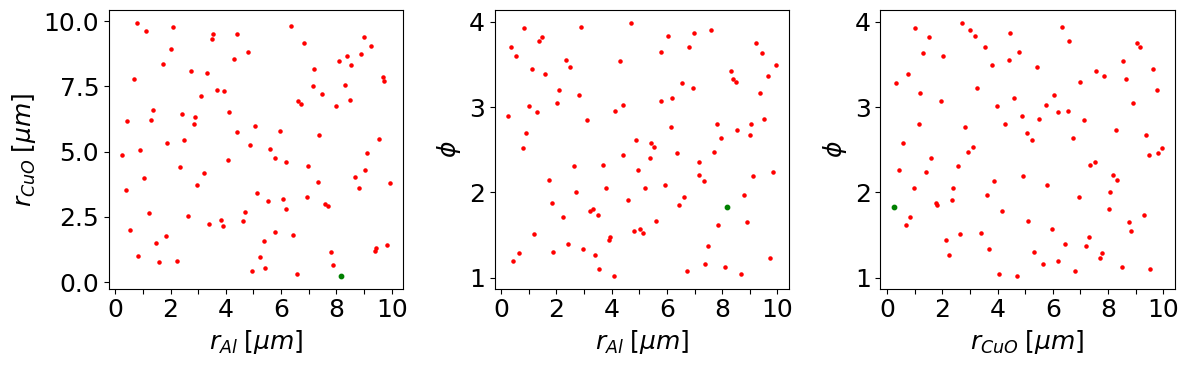

In [37]:
variables = names['features']
v = {
    'not_interesting': df[df['quality'] == 'not_interesting'],
    'outliers': df[(df['quality'] != 'not_interesting') & (lhs['quality'] != 'interest')],
    'interest': df[df['quality'] == 'interest'],
}
#colors = {'interest': "#E02401", 'not_interesting': "#A9B388", 'outliers': "black"}
colors = {'interest': "green", 'not_interesting': "red", 'outliers': "black"}
n_rows = len(variables)

fig, axs = plt.subplots(1, n_rows, figsize=(4*n_rows, 4))
pairs = [(variables[0], variables[1]), (variables[0], variables[2]), (variables[1], variables[2])]
for n_row, (x, y) in enumerate(pairs):
    axs[n_row].scatter(
        x=v['not_interesting'][x], y=v['not_interesting'][y], c=colors['not_interesting'], alpha=1.0, s=5
    )
    axs[n_row].scatter(
        x=v['outliers'][x], y=v['outliers'][y], c=colors['outliers'], marker='x', s=5
    )
    axs[n_row].scatter(
        x=v['interest'][x], y=v['interest'][y], c=colors['interest'], alpha=1.0, s=10
    )
    axs[n_row].set_xticks(np.arange(11))
    axs[n_row].set_xticklabels(['0', '', '2', '', '4', '', '6', '', '8', '', '10'])
    if x == 'Al radius [micron]':
        axs[n_row].set_xlabel(r'$r_{Al} \;[\mu m]$')
    else:
        axs[n_row].set_xlabel(r'$r_{CuO} \;[\mu m]$')
    if y == 'CuO radius [micron]':
        axs[n_row].set_ylabel(r'$r_{CuO} \;[\mu m]$')
    else:
        axs[n_row].set_ylabel(r'$\phi$')
fig.tight_layout()

# Store file

In [19]:
fig.savefig('img/name.png')